In [1]:
import numpy as np
import pandas as pd

In [2]:
# epl_data 자체를 가공하는 유틸리티 클라스를 정의.
class DataHandler:
    def __init__(self):
        pass
    
    def load_epl(self):
        # read data
        df = pd.read_csv('results.csv', encoding='cp949')
        
        # NaN 값이 들어있는 행을 모두 제거(2000-01 시즌부터 데이터를 활용), 인덱스를 리셋.
        df.dropna(axis=0, inplace=True)
        df.reset_index(inplace=True, drop=True)
        
        # 분석에 필요없는 정보는 삭제
        df.drop(['Referee'], axis=1, inplace=True)
        
        # epl_data에서 object 형식인 column들을 홈팀의 승점으로 변환시켜준다.
        df['FTR'] = df['FTR'].replace(['H', 'D', 'A'],[3, 1, 0])    
        df['HTR'] = df['HTR'].replace(['H', 'D', 'A'],[3, 1, 0])
        return df

    def season_split(self, df, index_reset=False):# index_reset을 True로 놓으면 시즌 데이터의 index도 0부터 시작.
        # 시즌별로 데이터를 나눈다.
        season_data_list = []

        seasons = []
        for i in range(22):
            if i <= 8:
                former = '0'+str(i); post = '0'+str(i+1)
            elif i == 9:
                former = '09'; post = '10'
            else:
                former = str(i); post = str(i+1)
            season = '20'+former+'-'+post
            seasons.append(season)
        
        for season in seasons:
            epl_season_data = df[df['Season']==season]
            if index_reset == True:
                epl_season_data.reset_index(inplace=True, drop=True)
            season_data_list.append(epl_season_data)
        return season_data_list
    
    # 원본 데이터에서 해당 팀이 치룬 모든 경기를 새로운 DataFrame으로 반환해준다.
    def all_team_matches(self, df, team):
        last_games_home = df[df['HomeTeam'] == team]
        last_games_away = df[df['AwayTeam'] == team]
        
        last_games = pd.concat([last_games_home, last_games_away])
        last_games.sort_values('DateTime', ascending=True, inplace=True)
        last_games.reset_index(drop=True, inplace=True)
        return last_games
    
    # 원본 데이터에서 입력한 팀의 홈에서의 경기들을 새로운 DataFrame으로 반환해준다.
    def home_matches(self, df, team):
        matches = df[df['HomeTeam'] == team]
        matches.reset_index(drop=True, inplace=True)
        return matches
    
    # 원본 데이터에서 입력한 팀의 원정에서의 경기들을 새로운 DataFrame으로 반환해준다.
    def away_matches(self, df, team):
        matches = df[df['AwayTeam'] == team]
        matches.reset_index(drop=True, inplace=True)
        return matches
    
    # 원본 데이터에서 입력한 두 팀 간의 경기들을 새로운 DataFrame으로 반환해준다. home_setting이 team1의 홈에서의 경기 결과들을 반환한다.
    def all_two_team_matches(self, df, team1, team2, home_setting=False):
        cond1 = (df['HomeTeam']==team1) & (df['AwayTeam']==team2)
        cond2 = (df['HomeTeam']==team2) & (df['AwayTeam']==team1)
        if home_setting == True:
            team1_home_matches = df[cond1]
            team1_home_matches.reset_index(drop=True, inplace=True)
            return team1_home_matches
        else:
            all_matches = df[cond1 | cond2]
            all_matches.reset_index(drop=True, inplace=True)
            return all_matches

In [3]:
dhd = DataHandler()
epl_data = dhd.load_epl()

In [4]:
# data_transform 안에서 필요한 유틸리티 클라스를 하나 정의.
class DataTransformer:
    # 클래스 변수로 DataHandler 객체를 놓는다.
    dhd = DataHandler()
    
    def __init__(self):
        pass
    
    # 경기 결과들이 들어간 DataFrame을 넣으면 시즌 정보(현재까지의 경기 정보) DataFrame을 반환.
    def season_result(self, season_data):    
        teams = set(season_data['HomeTeam'].values.tolist()) | set(season_data['AwayTeam'].values.tolist())

        team_datas = []
        for team in teams:
            Win = 0; Draw = 0; Lose = 0; Pts = 0; Score = 0; Loss = 0; GD = 0

            # 홈 경기 결과 정리
            home_matches = season_data[season_data['HomeTeam']==team]

            Win += home_matches[home_matches['FTR']==3].shape[0]
            Draw += home_matches[home_matches['FTR']==1].shape[0]
            Lose += home_matches[home_matches['FTR']==0].shape[0]

            Score += home_matches['FTHG'].sum()
            Loss += home_matches['FTAG'].sum()

            # 어웨이 경기 결과 정리
            away_matches = season_data[season_data['AwayTeam']==team]

            Win += away_matches[away_matches['FTR']==0].shape[0]
            Draw += away_matches[away_matches['FTR']==1].shape[0]
            Lose += away_matches[away_matches['FTR']==3].shape[0]

            Score += away_matches['FTAG'].sum()
            Loss += away_matches['FTHG'].sum()

            # 승점, 골득실 정리
            Pts = Win*3 + Draw*1; GD = Score - Loss

            team_data = [team, Win, Draw, Lose, Pts, Score, Loss, GD]
            team_datas.append(team_data)

        col_name = ['Team', 'W', 'D', 'L', 'Pts', 'Score','Loss', 'GD']
        season_result = pd.DataFrame(team_datas, columns = col_name)
        season_result.sort_values(['Pts', 'GD', 'Score'], ascending=[False, False, False], inplace=True)
        season_result.reset_index(inplace=True, drop=True)
        season_result.reset_index(inplace=True)
        season_result['index'] += 1
        season_result.columns = ['Rank', 'Team', 'W', 'D', 'L', 'Pts', 'Score','Loss', 'GD']
        return season_result
    
    # Season, HomeTeam, AwayTeam 정보 등록, Last Season Rank(LSR)도 업데이트. 지난 시즌 순위의 차이를 의미(Away-Home)
    def Season_ht_at_LSR_update(self, epl_data, season, season_idx, ht, at, new_data={}): # input은 현 시즌 기준.
        season_data = DataTransformer.dhd.season_split(epl_data)[season_idx-1]
        last_sr = self.season_result(season_data=season_data)    # 지난 Season의 순위 Table.
        new_data['Season'] = season; new_data['HomeTeam'] = ht; new_data['AwayTeam'] = at
        
        if ht not in last_sr['Team'].values.tolist():
            htr = 21
        else:
            htr = last_sr[last_sr['Team']==ht].iloc[0, 0]
        
        if at not in last_sr['Team'].values.tolist():
            atr = 21
        else:
            atr = last_sr[last_sr['Team']==at].iloc[0, 0]
        
        new_data['LSR'] = atr - htr
        return new_data
    
    # .iloc을 활용하여 이전 n 경기들을 가져옴.
    # 홈팀/어웨이 팀의 지난 n경기 스탯으로부터 가져올 수 있는 정보: FTG, FTR, HTG, HTR, S, ST, C, F, Y, Rn, R1
    def last_n_stat_update(self, epl_data, ht, at, dt, last_game=5, new_data={}):
        home_team_last_games = self.dhd.all_team_matches(epl_data, ht)
        away_team_last_games = self.dhd.all_team_matches(epl_data, at)
        
        match_idx = home_team_last_games.index[home_team_last_games['DateTime'] == dt].tolist()[0]    #  현 경기의'DateTime' 정보를 추출
        if match_idx - last_game < 0:    # 홈팀의 지난 n경기가 실제 경기수를 초과할 경우 데이터가 있는 첫 경기부터 반영
            ht_last_n = home_team_last_games.iloc[0:match_idx]
        else:
            ht_last_n = home_team_last_games.iloc[match_idx-last_game:match_idx]
            
        if match_idx - last_game < 0:    # 어웨이팀의 지난 n경기가 실제 경기수를 초과할 경우 데이터가 있는 첫 경기부터 반영
            at_last_n = away_team_last_games.iloc[0:match_idx]
        else:
            at_last_n = away_team_last_games.iloc[match_idx-last_game:match_idx]
        
        ht_last_n_stats = [0]*11    # 순서대로 FTG, FTR, HTG, HTR, S, ST, C, F, Y, Rn, R1를 뜻하기로 한다.
        for idx, match in ht_last_n.iterrows():
            if idx == 0:
                if match['HomeTeam'] == ht:
                    ht_last_n_stats[-1] += match['HR']
                else:
                    ht_last_n_stats[-1] += match['AR']
            
            if match['HomeTeam'] == ht:
                for n, stat in enumerate(match.loc[['FTHG', 'FTR', 'HTHG', 'HTR', 'HS', 'HST', 'HC', 'HF', 'HY', 'HR']].tolist()):
                    ht_last_n_stats[n] += stat
            else:
                temp_lst = match.loc[['FTAG', 'FTR', 'HTAG', 'HTR', 'AS', 'AST', 'AC', 'AF', 'AY', 'AR']].tolist()
                if temp_lst[1] != 1:
                    temp_lst[1] = 3-temp_lst[1]
                if temp_lst[3] != 1:
                    temp_lst[3] = 3-temp_lst[3]
                for n, stat in enumerate(temp_lst):
                    ht_last_n_stats[n] += stat
        
        at_last_n_stats = [0]*11    # 순서대로 FTG, FTR, HTG, HTR, S, ST, C, F, Y, Rn, R1를 뜻하기로 한다.
        for idx, match in at_last_n.iterrows():
            if idx == 0:
                if match['HomeTeam'] == at:
                    at_last_n_stats[-1] += match['HR']
                else:
                    at_last_n_stats[-1] += match['AR']
            
            if match['HomeTeam'] == at:
                for n, stat in enumerate(match.loc[['FTHG', 'FTR', 'HTHG', 'HTR', 'HS', 'HST', 'HC', 'HF', 'HY', 'HR']].tolist()):
                    at_last_n_stats[n] += stat
            else:
                temp_lst = match.loc[['FTAG', 'FTR', 'HTAG', 'HTR', 'AS', 'AST', 'AC', 'AF', 'AY', 'AR']].tolist()
                if temp_lst[1] != 1:
                    temp_lst[1] = 3-temp_lst[1]
                if temp_lst[3] != 1:
                    temp_lst[3] = 3-temp_lst[3]
                for n, stat in enumerate(temp_lst):
                    at_last_n_stats[n] += stat
        
        key_list = ['FTG', 'FTR', 'HTG', 'HTR', 'S', 'ST', 'C', 'F', 'Y', 'Rn', 'R1']
        for i, key in enumerate(key_list):
            new_data[key] = ht_last_n_stats[i] - at_last_n_stats[i]
        return new_data
    
    # CSR(Current Season Rank) 업데이트. 현 시즌 순위의 차이를 의미(Away-Home), ignore값이 있으면 설정한 만큼은 default 0으로 함.
    def CSR_update(self, epl_data, season_idx, idx, ht, at, ignore=3, new_data={}):
        season_data = self.dhd.season_split(epl_data, index_reset=False)[season_idx]
        current_data = epl_data.iloc[season_idx*380:idx, :]
        current_result = self.season_result(current_data)
        if len(current_data) <= ignore*10:
            new_data['CSR'] = 0
        else:
            new_data['CSR'] = current_result[current_result['Team']==at].iloc[0, 0] - current_result[current_result['Team']==ht].iloc[0, 0]
        return new_data
    
    # LHAP(Last Home-Away Points) 업데이트.
    def LHAP_update(self, epl_data, ht, at, dt, last_game=3, new_data={}):
        ht_matches = self.dhd.home_matches(epl_data, ht)
        at_matches = self.dhd.away_matches(epl_data, at)
        
        match_idx = ht_matches.index[ht_matches['DateTime'] == dt].tolist()[0]    #  현 경기의'DateTime' 정보를 추출
        if match_idx - last_game < 0:    # 홈팀의 지난 n경기가 실제 경기수를 초과할 경우 데이터가 있는 첫 경기부터 반영
            ht_last_n = ht_matches.iloc[0:match_idx]
        else:
            ht_last_n = ht_matches.iloc[match_idx-last_game:match_idx]
            
        if match_idx - last_game < 0:    # 어웨이팀의 지난 n경기가 실제 경기수를 초과할 경우 데이터가 있는 첫 경기부터 반영
            at_last_n = at_matches.iloc[0:match_idx]
        else:
            at_last_n = at_matches.iloc[match_idx-last_game:match_idx]
        
        ht_pts = ht_last_n['FTR'].sum()
        at_pts = 0
        for idx, match in at_last_n.iterrows():
            if match['FTR'] == 1:
                at_pts += 1
            else:
                at_pts += (3-match['FTR'])
        new_data['LHAP'] = ht_pts - at_pts
        return ht_last_n, at_last_n, new_data
    
    # LMP(Last Match Pts), LMHAP(Last Match Hmoe-Away Pts) 업데이트.
    def LMP_LMHAP_update(self, epl_data, ht, at, dt, last_game=5, new_data={}):
        all_matches = self.dhd.all_two_team_matches(epl_data, ht, at, home_setting=False)
        home_matches = self.dhd.all_two_team_matches(epl_data, ht, at, home_setting=True)
        
        all_match_idx = all_matches.index[all_matches['DateTime'] == dt].tolist()[0]    #  현 경기의'DateTime' 정보를 추출
        home_match_idx = home_matches.index[home_matches['DateTime'] == dt].tolist()[0]    #  현 경기의'DateTime' 정보를 추출
        
        if all_match_idx - last_game < 0:    # 홈팀의 지난 n경기가 실제 경기수를 초과할 경우 데이터가 있는 첫 경기부터 반영
            all_last_n = all_matches.iloc[0:all_match_idx]
        else:
            all_last_n = all_matches.iloc[all_match_idx-last_game:all_match_idx]
            
        if home_match_idx - last_game < 0:    # 어웨이팀의 지난 n경기가 실제 경기수를 초과할 경우 데이터가 있는 첫 경기부터 반영
            home_last_n = home_matches.iloc[0:home_match_idx]
        else:
            home_last_n = home_matches.iloc[home_match_idx-last_game:home_match_idx]
        
        # LMP 먼저
        home_pts = 0; away_pts = 0
        for idx, match in all_last_n.iterrows():
            if match['FTR'] == 1:
                continue
            else:
                hp = match['FTR']; ap = 3-match['FTR']
                if match['HomeTeam'] == ht:
                    home_pts += hp; away_pts += ap
                else:
                    home_pts += ap; away_pts += hp
        new_data['LMP'] = home_pts - away_pts
        
        # LMHAP
        home_pts = 0; away_pts = 0
        for idx, match in home_last_n.iterrows():
            if match['FTR'] == 1:
                continue
            else:
                home_pts += match['FTR']; away_pts += 3-match['FTR']
        new_data['LMHAP'] = home_pts - away_pts
        return new_data

In [5]:
# 머신러닝에 적합하도록 원본 데이터를 변환. 첫 시즌의 데이터(00-01시즌)는 지난 시즌 순위 참고용으로만 사용하게 된다.
# last_game: 지난 n 경기의 승/무/패 결과를 반영하여 적용, average_stat: 지난 n 경기의 스탯을 반영하여 적용, ignore: 시즌 초기 n경기 순위 결과 무시
# rewrite_csv가 True면 처음부터. 단, csv_file이 'w' 모드일 때에만 가능.
# csv_file이 'r'모드이면 그대로 가져와서 반환. 'w'모드이면 파일을 작성.
# write_unit은 w 모드일 때 끊어서 작성하는 개수.
def data_transform(epl_data, last_game = 5, average_stat = 5, ignore = 3, csv_file = 'r', write_unit = False, rewrite_csv = False):
    if csv_file == 'r':
        if rewrite_csv == True:
            raise ValueError('csv_file 파라미터 오류: 쓰기(w)모드일 때에만 rewrite_csv를 True로 입력할 수 있음')
        if write_unit != False:
            raise ValueError('csv_file 파라미터 오류: 쓰기(w)모드일 때에만 write_unit을 입력할 수 있음')
        epl_data_trans = pd.read_csv('transformed_data.csv', encoding='cp949')
        return epl_data_trans
    
    elif csv_file != 'w':
        raise ValueError('csv_file 파라미터 오류: 쓰기(w)모드 혹은 읽기(r)모드 중에 선택')
    
    # csv_file 모드가 'w'모드인 경우.
    if type(write_unit) != int:
        raise ValueError('write_unit 파라미터 오류: 숫자나 False 값만 입력할 수 있음')
    if write_unit <= 0:
        raise ValueError('write_unit 파라미터 오류: 0보다 작을 수 없음')
    
    if rewrite_csv == True:
        col_names = ['Season', 'HomeTeam', 'AwayTeam', 'FTG', 'FTR', 'HTG', 'HTR', 'S', 'ST', 'C', 'F', 'Y', 'Rn', 'R1', 'LSR', 'CSR', 'LHAP', 'LMP', 'LMHAP', 'Result']
        epl_data_trans = pd.DataFrame(data=[], columns=col_names)
        start_point = 0
    else:
        col_names = ['Season', 'HomeTeam', 'AwayTeam', 'FTG', 'FTR', 'HTG', 'HTR', 'S', 'ST', 'C', 'F', 'Y', 'Rn', 'R1', 'LSR', 'CSR', 'LHAP', 'LMP', 'LMHAP', 'Result']
        epl_data_trans = pd.read_csv('transformed_data.csv', encoding='cp949')
        start_point = 380 + len(epl_data_trans)
    
    dtf = DataTransformer()    # 데이터 변환 유틸리티 객체
    
    for idx, match in epl_data.iterrows():
        if idx < 380:    # 첫 시즌인 00-01시즌은 데이터로 사용하지 않는다.
            continue
        
        if idx < start_point:    # 이미 쓴 데이터는 지나친다.
            continue
        
        if idx >= start_point+write_unit:    # 단위를 끊어서 작성하기 위함.
            break
        
        new_data = {}
        for column in col_names:
            new_data[column] = None    # Column들을 Key로 등록
        
        season = match['Season']; ht = match['HomeTeam']; at = match['AwayTeam']; dt = match['DateTime']    # 여기서는 그냥 가져와도 문제x(loc, iloc 사용 안해도 됨)
        season_idx = int(season[2:4])
        
        # Season, HomeTeam, AwayTeam 정보 등록, Last Season Rank(LSR)도 업데이트. 지난 시즌 순위의 차이를 의미(Away-Home)
        dtf.Season_ht_at_LSR_update(epl_data, season, season_idx, ht, at, new_data)
        
        # Result 업데이트.
        new_data['Result'] = match['FTR']
        
        # .iloc을 활용하여 이전 n 경기들을 가져옴.
        # 홈팀/어웨이 팀의 지난 n경기 스탯으로부터 가져올 수 있는 정보: FTG, FTR, HTG, HTR, S, ST, C, F, Y, Rn, R1
        dtf.last_n_stat_update(epl_data, ht, at, dt, last_game, new_data)
        
        # CSR(Current Season Rank) 업데이트. 현 시즌 순위의 차이를 의미(Away-Home), ignore값이 있으면 설정한 만큼은 0으로 함.
        dtf.CSR_update(epl_data, season_idx, idx, ht, at, ignore, new_data)
        
        # LHAP(Last Home-Away Points) 업데이트.
        dtf.LHAP_update(epl_data, ht, at, dt, last_game, new_data)
        
        # LMP(Last Match Pts), LMHAP(Last Match Hmoe-Away Pts) 업데이트.
        dtf.LMP_LMHAP_update(epl_data, ht, at, dt, last_game, new_data)
        
        # 데이터를 새로운 DataFrame 객체에 추가
        epl_data_trans = epl_data_trans.append(new_data, ignore_index=True)    
        
        """"""
        print('파일 작성 진행상황: {0}'.format(idx))
    pd.DataFrame(columns=epl_data_trans.columns).to_csv("transformed_data.csv", index=False)
    epl_data_trans.to_csv('transformed_data.csv', header=None, mode='a')
    return 0

In [9]:
ml_data = data_transform(epl_data)

In [10]:
ml_data

,Season,HomeTeam,AwayTeam,FTG,FTR,HTG,HTR,S,ST,C,F,Y,Rn,R1,LSR,CSR,LHAP,LMP,LMHAP,Result
0,2001-02,Charlton,Everton,0,3,1.0,5,-4.0,2.0,7.0,-26.0,-9.0,-1.0,0.0,7,0,4,0,3,0
1,2001-02,Derby,Blackburn,-8,-3,0.0,0,-16.0,-18.0,-8.0,-1.0,-3.0,1.0,0.0,4,0,1,0,0,3
2,2001-02,Leeds,Southampton,8,5,5.0,3,15.0,18.0,11.0,7.0,4.0,1.0,0.0,6,0,11,0,3,3
3,2001-02,Leicester,Bolton,-1,-1,-2.0,2,7.0,7.0,-5.0,17.0,9.0,0.0,0.0,8,0,3,0,0,0
4,2001-02,Liverpool,West Ham,8,10,1.0,6,1.0,3.0,-7.0,-9.0,-7.0,0.0,0.0,12,0,9,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,2021-22,Brighton,Arsenal,-11,-3,-2.0,-2,-21.0,-31.0,-4.0,1.0,5.0,0.0,0.0,-8,5,-3,0,3,1
7666,2021-22,Crystal Palace,Leicester,-4,-3,-1.0,1,13.0,-7.0,-5.0,-2.0,-7.0,0.0,0.0,-9,-1,-1,-6,3,1
7667,2021-22,Tottenham,Aston Villa,3,6,2.0,8,43.0,21.0,25.0,47.0,9.0,1.0,0.0,4,-4,9,9,3,3
7668,2021-22,West Ham,Brentford,9,8,3.0,8,73.0,25.0,28.0,41.0,4.0,1.0,0.0,15,3,7,0,0,0


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

train = ml_data.iloc[:6136,:]
test = ml_data.iloc[6136:, :]
X_train = train.iloc[:, 3:-1].astype('float64')
y_train = train['Result'].astype('float64')
X_test = test.iloc[:, 3:-1].astype('float64')
y_test = test['Result'].astype('float64')

#x, y, z, i = train_test_split(ml_data.iloc[:, 3:15], ml_data['Result'], test_size=0.2, random_state=11)

In [12]:
X_train

,FTG,FTR,HTG,HTR,S,ST,C,F,Y,Rn,R1,LSR,CSR,LHAP,LMP,LMHAP
0,0.0,3.0,1.0,5.0,-4.0,2.0,7.0,-26.0,-9.0,-1.0,0.0,7.0,0.0,4.0,0.0,3.0
1,-8.0,-3.0,0.0,0.0,-16.0,-18.0,-8.0,-1.0,-3.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0
2,8.0,5.0,5.0,3.0,15.0,18.0,11.0,7.0,4.0,1.0,0.0,6.0,0.0,11.0,0.0,3.0
3,-1.0,-1.0,-2.0,2.0,7.0,7.0,-5.0,17.0,9.0,0.0,0.0,8.0,0.0,3.0,0.0,0.0
4,8.0,10.0,1.0,6.0,1.0,3.0,-7.0,-9.0,-7.0,0.0,0.0,12.0,0.0,9.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,2.0,4.0,2.0,6.0,42.0,10.0,18.0,57.0,9.0,1.0,0.0,2.0,1.0,9.0,3.0,6.0
6132,2.0,-3.0,0.0,-1.0,-34.0,-23.0,-21.0,-29.0,-3.0,0.0,0.0,-8.0,-8.0,-3.0,0.0,0.0
6133,16.0,13.0,6.0,8.0,93.0,35.0,41.0,46.0,9.0,2.0,0.0,11.0,19.0,13.0,9.0,15.0
6134,-10.0,-3.0,-3.0,-5.0,-8.0,-28.0,0.0,5.0,-5.0,0.0,0.0,-2.0,-7.0,-4.0,0.0,-9.0


In [13]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

params = {'max_depth':[8, 12, 16, 20], 'min_samples_split':[16, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

결정 트리 예측 정확도: 0.4231
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   16.2s finished


GridSearchCV 최고 평균 정확도 수치: 0.4824
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [14]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.5104


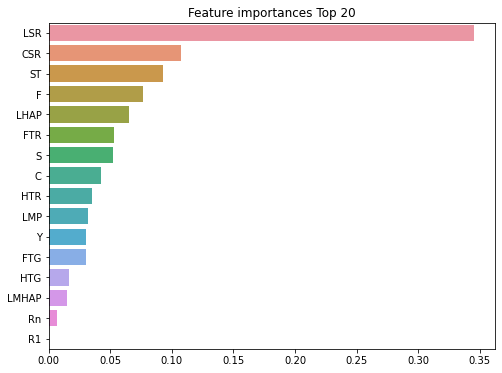

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances_values = pd.Series(ftr_importances_values, index=X_train.columns)
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances_values.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()